In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches
import os
from PIL import Image

In [2]:
def gen_box(stuff):

    x_low = int(stuff.find('xmin').text)
    y_low = int(stuff.find('ymin').text)
    x_high = int(stuff.find('xmax').text)
    y_high = int(stuff.find('ymax').text)

    return [x_low, y_low, x_high, y_high]

def gen_lab(stuff):

    if stuff.find('name').text == 'with_mask':
        return 1
    elif stuff.find('name').text == 'mask_weared_incorrect':
        return 2
    else:
        return 0

def gen_tar(id, file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, features= "lxml-xml")
        objects = soup.find_all('object')

        num_obs = len(objects)


        boxes = []
        labels = []

        for i in objects:
            boxes.append(gen_box(i))
            labels.append(gen_lab(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        img_id = torch.tensor([id])

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id

        return target


In [3]:
imgs = list(sorted(os.listdir("images/")))

In [4]:
labels = list(sorted(os.listdir("annotations/")))

In [5]:
class create_Mask(object):
    def __init__(self, transforms):
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir("images/")))

    def __getitem__(self, idx):
        image = 'maksssksksss'+ str(idx) + '.png'
        label = 'maksssksksss'+ str(idx) + '.xml'

        image_path = os.path.join('images/', image)
        label_path = os.path.join('annotations/', label)

        img = Image.open(image_path).convert('RGB')

        target = gen_tar(idx, label_path)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [6]:
data_tr = transforms.Compose([
    transforms.ToTensor(),
])

In [7]:
def fn_collate(batch):
    return tuple(zip(*batch))

data = create_Mask(data_tr)
data_loader = torch.utils.data.DataLoader(
    data, batch_size=4, collate_fn = fn_collate
)

# Model

In [8]:
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(features, num_classes)

    return model

In [9]:
model = get_model(3)

In [11]:
device = torch.device('cuda')
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

[{'boxes': tensor([[ 79., 105., 109., 142.],
        [185., 100., 226., 144.],
        [325.,  90., 360., 141.]], device='cuda:0'), 'labels': tensor([0, 1, 0], device='cuda:0'), 'image_id': tensor([0], device='cuda:0')}, {'boxes': tensor([[321.,  34., 354.,  69.],
        [224.,  38., 261.,  73.],
        [299.,  58., 315.,  81.],
        [143.,  74., 174., 115.],
        [ 74.,  69.,  95.,  99.],
        [191.,  67., 221.,  93.],
        [ 21.,  73.,  44.,  93.],
        [369.,  70., 398.,  99.],
        [ 83.,  56., 111.,  89.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0], device='cuda:0'), 'image_id': tensor([1], device='cuda:0')}, {'boxes': tensor([[ 68.,  42., 105.,  69.],
        [154.,  47., 178.,  74.],
        [238.,  34., 262.,  69.],
        [333.,  31., 366.,  65.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 2], device='cuda:0'), 'image_id': tensor([2], device='cuda:0')}, {'boxes': tensor([[ 52.,  53.,  73.,  76.],
        [ 72.,  53.,  92.,  75.],
  

# Training


In [13]:
epochs = 50
model.to(device)


parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(parameters, lr = 0.0001)

len_dataloader = len(data_loader)

for epoch in range(epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
    print(epoch_loss)

tensor(87.7257, device='cuda:0', grad_fn=<AddBackward0>)
tensor(68.4077, device='cuda:0', grad_fn=<AddBackward0>)
tensor(53.2149, device='cuda:0', grad_fn=<AddBackward0>)
tensor(47.1992, device='cuda:0', grad_fn=<AddBackward0>)
tensor(43.9382, device='cuda:0', grad_fn=<AddBackward0>)
tensor(38.6589, device='cuda:0', grad_fn=<AddBackward0>)
tensor(39.5931, device='cuda:0', grad_fn=<AddBackward0>)
tensor(36.9470, device='cuda:0', grad_fn=<AddBackward0>)
tensor(30.2222, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.4021, device='cuda:0', grad_fn=<AddBackward0>)
tensor(26.2587, device='cuda:0', grad_fn=<AddBackward0>)
tensor(27.0672, device='cuda:0', grad_fn=<AddBackward0>)
tensor(26.3137, device='cuda:0', grad_fn=<AddBackward0>)
tensor(22.8425, device='cuda:0', grad_fn=<AddBackward0>)
tensor(22.8190, device='cuda:0', grad_fn=<AddBackward0>)
tensor(25.6700, device='cuda:0', grad_fn=<AddBackward0>)
tensor(22.5681, device='cuda:0', grad_fn=<AddBackward0>)
tensor(20.8784, device='cuda:0'

In [15]:
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    break

In [16]:
model.eval()
preds = model(imgs)
preds

[{'boxes': tensor([[183.6424,  99.8010, 228.1592, 144.9729]], device='cuda:0',
         grad_fn=<StackBackward>),
  'labels': tensor([1], device='cuda:0'),
  'scores': tensor([0.9996], device='cuda:0', grad_fn=<IndexBackward>)},
 {'boxes': tensor([[225.5062,  36.0104, 259.6630,  76.1395],
          [319.4422,  34.0581, 353.8252,  71.2642],
          [145.5338,  74.6750, 172.2819, 114.4012],
          [ 21.8277,  73.7058,  43.0545,  93.3913],
          [298.5349,  59.6773, 314.3528,  79.8118],
          [197.3454,  69.2291, 216.3959,  93.2510],
          [319.9978,  33.8049, 352.0936,  70.3141],
          [144.9791,  74.8110, 171.9114, 109.7671],
          [196.7417,  64.8882, 217.9633,  92.8709],
          [369.8618,  71.9395, 395.2695,  97.5882],
          [299.5906,  59.3240, 314.0041,  79.6396]], device='cuda:0',
         grad_fn=<StackBackward>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2], device='cuda:0'),
  'scores': tensor([0.9995, 0.9957, 0.9951, 0.9946, 0.9752, 0.942

In [17]:
def plot_image(img_tensor, annotation):
    
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    
    for box in annotation["boxes"]:
        xmin, ymin, xmax, ymax = box

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

Prediction


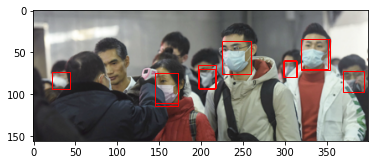

Target


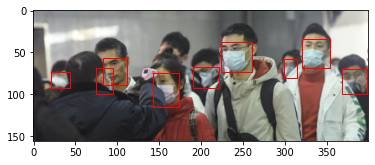

In [23]:
print("Prediction")
plot_image(imgs[1], preds[1])
print("Target")
plot_image(imgs[1], annotations[1])